Slab Subduction
======

This two dimensional subduction model has a dense, high viscosity 3 layered plate overlying a lower viscosity mantle. The upper and lower plate layers have a visco-plastic rheology, yielding under large stresses. The middle, core layer has a viscous only rheology, maintaining strength during bending. The top 1000 km of the mantle is included, the upper & lower mantle is partitioned with a viscosity contrast of 100x at 600 km depth. The velocity boundary conditions on the domain are period side, free-slip top and no-slip bottom wall. 

**References**

1. OzBench, M.; Regenauer-Lieb, K.; Stegman, D. R.; Morra, G.; Farrington, R.; Hale, A.; May, D. A.; Freeman, J.; Bourgouin, L.; Mühlhaus, H. & Moresi, L. A model comparison study of large-scale mantle-lithosphere dynamics driven by subduction. Physics of the Earth and Planetary Interiors, 2008, 171, 224-234. [OzBench, 2008](http://www.sciencedirect.com/science/article/pii/S0031920108002318)

**What's in this one?**
visc lith = 800
visc asthen = 0.1 
thickness asthen = 100m 

In [1]:
import underworld as uw
import UWGeodynamics as GEO
import math
from underworld import function as fn
import underworld.visualisation as vis
import numpy as np
import os

rank = uw.mpi.rank

loaded rc file /opt/venv/lib/python3.7/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
#u = GEO.UnitRegistry DOESN'T WORK LIKE IT SHOULD

In [3]:
refdepth = 2900. * 10**3 #* u.meter
bodyforce = 3300. * 9.81 #* u.kilogram / u.meter**3 * 9.81 * u.meter / u.second**2
refrho = 3300. #* u.kilogram / u.meter**3
refvisc = 10. ** 21 #* u.pascal * u.second 
refg = 9.8 #*u.meters / u.second**2
reft = refvisc / (refrho * refdepth) #* u.second
refvelo = refdepth / reft #* u.meter / u.second 

In [4]:
outputPath = os.path.join(os.path.abspath("."),"output/AccuVisc3/")

if rank==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.mpi.barrier()

**Setup parameters**


In [5]:
Res =  80*2 
Xmax = 3500. * 10**3 / refdepth
Xmin = -2000. * 10**3 / refdepth
Ymax = 0. 
Ymin = -refdepth / refdepth

boxL = Xmax - Xmin
boxH = Ymax - Ymin

xRes = int(Res * boxL)
yRes = int(Res * boxH)

**Create mesh and finite element variables**

In [6]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (xRes, yRes), 
                                 minCoord    = (Xmin, Ymin), 
                                 maxCoord    = (Xmax, Ymax),
                                 periodic    = [False, False] ) 


velocityField   = mesh.add_variable(         nodeDofCount=2 )
pressureField   = mesh.subMesh.add_variable( nodeDofCount=1 )

**Create a particle swarm**

In [7]:
swarm = uw.swarm.Swarm( mesh=mesh, particleEscape=True )
materialVariable   = swarm.add_variable( dataType="int", count=1 )
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=25 )
swarm.populate_using_layout( layout=swarmLayout )

In [8]:
velocity = -(0.150 / 4 / 31536000.) / refvelo # convert meters/year to meters/second then nondimensionalize

**Allocate materials to particles**

In [9]:
angle = np.deg2rad(45)
aangle = np.deg2rad(30-8)
apex = 0.0
slabh = 100 * 10**3 / refdepth

#calcualte top and bottom of dipping slab against left wall
dtop= 0. + np.tan(angle) * Xmin
dbtm = dtop - slabh

In [10]:
dipslab = np.array([(apex, 0.0),
                     (apex, 0.0 - slabh),
                     (Xmin , dbtm),
                     (Xmin , dtop)])

flatslab = np.array([(apex, 0.0),
                    (Xmax, 0.),
                    (Xmax, 0. - slabh),
                    (apex, 0. - slabh)])


In [11]:
#m=(1-dtop) / (apex - 0)
m = dtop / Xmin

In [12]:
asThick = 200. * 10**3 / refdepth
asTop = 0.0 - slabh
asbot = asTop - asThick
asdip = asbot- 400. * 10**3 / refdepth
dasTop = asbot-np.tan(aangle) * 500 * 10**3 / refdepth + asThick
dasbot = asbot-np.tan(aangle) * 500 * 10**3 / refdepth
daspoint = asdip / m

In [13]:
# initialise the 'materialVariable' data to represent two different materials. 
MantleIndex      = 0
slabIndex        = 1
asthenIndex      = 2

# Initial material layout has a flat lying slab with at 15\degree perturbation

fslabUpShape = np.array([(Xmax-100. * 10**3 / refdepth, Ymax),(Xmax, Ymax),(Xmax, Ymax-slabh),(Xmax-100. * 10**3 / refdepth, Ymax-slabh)])
asthenUpShape = np.array([(Xmax-100. * 10**3 / refdepth, asTop),(Xmax, asTop),(Xmax, asbot),(Xmax-100. * 10**3 / refdepth, asbot)])
mantUpShape = np.array([(Xmax-100. * 10**3 / refdepth, asbot),(Xmax, asbot),(Xmax, Ymin),(Xmax-100. * 10**3 / refdepth, Ymin)])
asthenUp    = fn.shape.Polygon( asthenUpShape )
fslabUp = fn.shape.Polygon( fslabUpShape )
mantUp = fn.shape.Polygon( mantUpShape )

asthenShape    = np.array([ (apex, asTop), (Xmax, asTop), (Xmax, asbot), (apex, asbot), (daspoint,asdip)]) #(apex-0.5,dasbot), (apex-0.5,dasTop)])

fslab  = fn.shape.Polygon( flatslab )
dslab = fn.shape.Polygon( dipslab )

asthen    = fn.shape.Polygon( asthenShape )


# initialise everying to be upper mantle material
materialVariable.data[:] = MantleIndex

# change matieral index if the particle is not upper mantle
for index in range( len(swarm.particleCoordinates.data) ):
    coord = swarm.particleCoordinates.data[index][:]
    if fslab.evaluate(tuple(coord)) or dslab.evaluate(tuple(coord)):
            materialVariable.data[index] = slabIndex
    elif asthen.evaluate(tuple(coord)):
            materialVariable.data[index] = asthenIndex


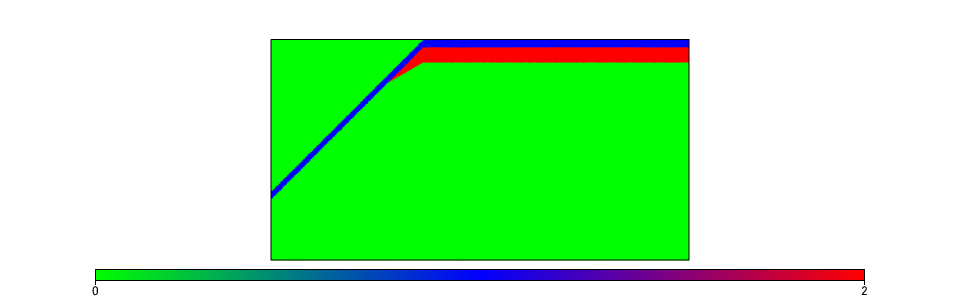

In [14]:
store = vis.Store('output/AccuVisc3')
figParticle = vis.Figure( store, figsize=(960,300), name="Particles" )
figParticle.append( vis.objects.Points(swarm, materialVariable, pointSize=2, colours='green blue red') )
figParticle.show()

**Plot the initial positions for the particle swarm and colour by material type**

We are using a vis store object to keep all our figures together and allow them to be revisualised later so create this here and pass it to all the figures created later. We'll also name this figure to make it easy to find later when revisualising.

Set up material parameters and functions
----

Here the functions for density, viscosity, gravity and buoyancy are set. 

**Viscosity function**

The slab is simple and yields. the upper and lower mantle have the same viscosity for now (future iterations will have different viscosity laws for each, powerlaw in upper and newtonian in lower). The thin asthenosphere analog has a very low viscosity that will be varied for testing. 

In [15]:
MantleViscosity      =  10. ** 20 / refvisc
slabViscosity        =  10. ** 23 / refvisc
asthenViscosity      =  10. ** 19 / refvisc

# The yeilding of the upper slab is dependent on the strain rate.
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))
cohesion = 0.06
vonMises = 0.5 * cohesion / (strainRate_2ndInvariant+1.0e-18)

# The upper slab viscosity is the minimum of the 'slabViscosity' or the 'vonMises' 
slabYieldvisc = fn.exception.SafeMaths( fn.misc.min(vonMises, slabViscosity) )

# Viscosity function for the materials 
viscosityMap = { MantleIndex      : MantleViscosity, 
                 slabIndex        : slabViscosity,
                 asthenIndex      : asthenViscosity}
viscosityMapFn = fn.branching.map( fn_key = materialVariable, mapping = viscosityMap )

Note: ``SafeMaths`` in the above cell refers to a function which checks the value passed inside for any infinite or other not-a-number type errors.

**Set the density function, vertical unit vector and Buoyancy Force function**


In [16]:
#density is same as slab

mantleDensity = 3300 / refrho
slabDensity   = 3500 / refrho
asthenDensity = (1 - .02) * 3300 / refrho   #2% density decrease
airDensity    = 0.000000001

densityMap = { MantleIndex : mantleDensity, 
               slabIndex    : slabDensity,
               asthenIndex      : asthenDensity}
densityFn = fn.branching.map( fn_key = materialVariable, mapping = densityMap )

# Define our vertical unit vector using a python tuple
z_hat = ( 0.0, 1.0 )

# now create a buoyancy force vector
buoyancyFn = -9.8 / refg * densityFn * z_hat

**Set initial and boundary conditions**

In [17]:
# set initial conditions (and boundary values)
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

#set up the moving wall condition

## setup slab velocities

In [18]:
#calculate the x and y velocities
us=np.cos(angle) * velocity

In [19]:
vs=np.sin(angle) * velocity

In [20]:
#grab the flat part of the slab
slab_handcrafted = mesh.specialSets['Empty']
for index,coord in enumerate(mesh.data):
    # grab only top right wall indices
    if coord[0] >= apex and 0. >= coord[1] >= 0. - slabh :
        slab_handcrafted.add(index)
        
#apply the velocity condition
velocityField.data[slab_handcrafted]=(velocity, 0.)


In [21]:
#grab the sinking part of the slab
sinkingslab_handcrafted = mesh.specialSets['Empty']
for index,coord in enumerate(mesh.data):
    # grab only top right wall indices
    if coord [0] < apex and m* coord[0] + 0.0 - slabh < coord[1] < m * coord[0] + 0.0 :
        sinkingslab_handcrafted.add(index)
        
#apply the velocity condition       coord[1] > dbtm and
velocityField.data[sinkingslab_handcrafted]=(us, vs)

In [22]:
#grab the left wall below the slab
belowslabL_handcrafted = mesh.specialSets['Empty']
for index,coord in enumerate(mesh.data):
    # grab only below the slab
    if coord[1] < dbtm and coord [0] < Xmin + 0.01 :
        belowslabL_handcrafted.add(index)
        
#apply the velocity condition
velocityField.data[belowslabL_handcrafted]=(0., 0.)

In [23]:
#grab the left wall below the slab
belowslabR_handcrafted = mesh.specialSets['Empty']
for index,coord in enumerate(mesh.data):
    # grab only below the slab
    if coord[1] < 0 - asbot and coord [0] > Xmax - 0.01 :
        belowslabR_handcrafted.add(index)
        
#apply the velocity condition
velocityField.data[belowslabR_handcrafted]=(0., 0.)

In [24]:
#grab the lith depths of the right wall
movingrightwall_handcrafted = mesh.specialSets['Empty']
for index,coord in enumerate(mesh.data):
    # grab only top right wall indices
    if coord[0]> Xmax - .01 and coord[1] > 0.0 - slabh:
        movingrightwall_handcrafted.add(index)
        
velocityField.data[movingrightwall_handcrafted]=(velocity, 0.)

In [25]:
c = asThick
a = dbtm
b = a - c


#grab the lith depths of the right wall
tinyLeft_handcrafted = mesh.specialSets['Empty']
for index,coord in enumerate(mesh.data):
    # grab only top right wall indices
    if coord[0] < Xmin + .01 and a >= coord[1] >= b:
        tinyLeft_handcrafted.add(index)
        velocityField.data[index]=(us*((c-(a-coord[1]))/c), vs*((c-(a-coord[1]))/c))
        
#velocityField.data[tinyLeft_handcrafted]=(velocity, 0.)

In [26]:
c = asThick
a = dtop + c
b = dtop


#grab the lith depths of the right wall
tinyLefttop_handcrafted = mesh.specialSets['Empty']
for index,coord in enumerate(mesh.data):
    # grab only top right wall indices
    if coord[0] < Xmin + .01 and a >= coord[1] >= b:
        tinyLefttop_handcrafted.add(index)
        velocityField.data[index]=(us*((c-(coord[1]-b))/c), vs*((c-(coord[1]-b))/c))
        
        
restLefttop_handcrafted = mesh.specialSets['Empty']
for index,coord in enumerate(mesh.data):
    # grab only top right wall indices
    if coord[0] < Xmin + .01 and coord[1] > a:
        restLefttop_handcrafted.add(index)

velocityField.data[restLefttop_handcrafted]=(0., 0.)

In [27]:
c = asThick
a = 0.-slabh
b = a-c

#grab the lith depths of the right wall
tinyRight_handcrafted = mesh.specialSets['Empty']
for index,coord in enumerate(mesh.data):
    # grab only top right wall indices
    if coord[0] > Xmax - .01 and a >= coord[1] >= b:
        tinyRight_handcrafted.add(index)
        velocityField.data[index]=(velocity*((c-(a-coord[1]))/c), 0.)
        
#velocityField.data[tinyLeft_handcrafted]=(velocity, 0.)

In [28]:
#movingleftwall_handcrafted = mesh.specialSets['Empty']
#for index,coord in enumerate(mesh.data):
#    # grab only left wall indices
#    if coord[0]<0.01 and dtop>coord[1]>dbtm:
#        movingleftwall_handcrafted.add(index)
        
#velocityField.data[movingleftwall_handcrafted]=(us,vs)

In [29]:
edgeWalls = mesh.specialSets['AllWalls_VertexSet']
topWalls = mesh.specialSets['Top_VertexSet']
btmWalls = mesh.specialSets['Bottom_VertexSet']

allWalls = edgeWalls + slab_handcrafted + sinkingslab_handcrafted

someWallsU = slab_handcrafted + sinkingslab_handcrafted + topWalls + belowslabL_handcrafted + belowslabR_handcrafted + tinyRight_handcrafted + tinyLeft_handcrafted +tinyLefttop_handcrafted + restLefttop_handcrafted

someWallsV = btmWalls + slab_handcrafted + sinkingslab_handcrafted + topWalls + tinyRight_handcrafted + tinyLeft_handcrafted +tinyLefttop_handcrafted


condition = uw.conditions.DirichletCondition(velocityField, (someWallsU,someWallsV) )


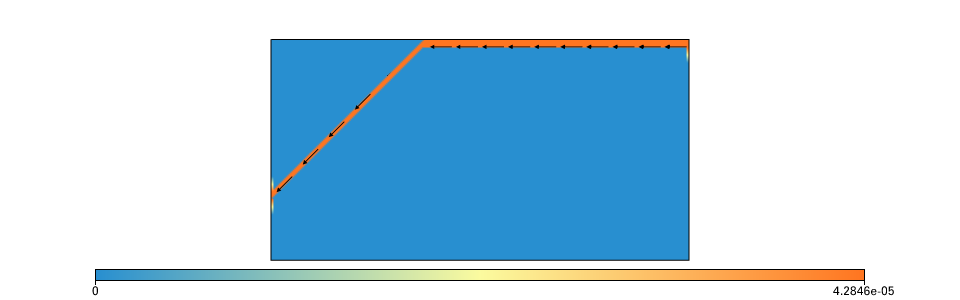

In [30]:
figVelocityMag = vis.Figure(figsize=(960,300))
figVelocityMag.append( vis.objects.Surface(mesh, fn.math.sqrt(fn.math.dot(velocityField,velocityField))) )
figVelocityMag.VectorArrows(mesh, velocityField)
figVelocityMag.show()

**System Setup**

In [31]:
# Initial linear slab viscosity setup
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = condition,
                               fn_viscosity  = viscosityMapFn, 
                               fn_bodyforce  = buoyancyFn )
# Create solver & solve
solver = uw.systems.Solver(stokes)

In [32]:
# use "mumps" direct solve, best for 2D models.
solver.set_inner_method("mumps")

In [33]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

**Analysis tools**

In [34]:
#Plot of Velocity Magnitude
figVelocityMag = vis.Figure(store, figsize=(960,300))
figVelocityMag.append( vis.objects.Surface(mesh, fn.math.sqrt(fn.math.dot(velocityField,velocityField))) )

#Plot of Strain Rate, 2nd Invariant
figStrainRate = vis.Figure(store, figsize=(960,300))
figStrainRate.append( vis.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True) )

#Plot of particles viscosity
figViscosity = vis.Figure(store, figsize=(960,300))
figViscosity.append( vis.objects.Points(swarm, viscosityMapFn, pointSize=2) )

#Plot of particles stress invariant
figStress = vis.Figure( store, figsize=(960,300) )
figStress.append( vis.objects.Points(swarm, 2.0*viscosityMapFn*strainRate_2ndInvariant, pointSize=2, logScale=True) )

#plot of velocity magnitude with vectors
figVelocityVecMag = vis.Figure(figsize=(960,300))
figVelocityVecMag.append( vis.objects.Surface(mesh, fn.math.sqrt(fn.math.dot(velocityField,velocityField))) )
figVelocityVecMag.VectorArrows(mesh, velocityField)

Main simulation loop
=======

The main time stepping loop begins here. Inside the time loop the velocity field is solved for via the Stokes system solver and then the swarm is advected using the advector integrator. Basic statistics are output to screen each timestep.

In [35]:
time = 0.  # Initial time
step = 0   # Initial timestep
maxSteps = 301   # Maximum timesteps (201 is recommended)
steps_output = 10   # output every 10 timesteps

In [36]:
swarm_popcontrol = uw.swarm.PopulationControl(
    swarm,
    deleteThreshold=0.002,
    splitThreshold=0.20,
    maxDeletions=0,
    maxSplits=80,
    aggressive=True,
    aggressiveThreshold=0.98,
    particlesPerCell=20,
)    

In [37]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    # Advect using this timestep size.
    advector.integrate(dt)
    
    swarm_popcontrol.repopulate()
    
    for index in range( len(swarm.particleCoordinates.data) ):
        coord = swarm.particleCoordinates.data[index][:]
        if fslabUp.evaluate(tuple(coord)):
            materialVariable.data[index] = slabIndex
        if asthenUp.evaluate(tuple(coord)):
            materialVariable.data[index] = asthenIndex
        if mantUp.evaluate(tuple(coord)):
            materialVariable.data[index] = MantleIndex

   

    return time+dt, step+1

In [38]:
while step < maxSteps:
    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True)
    # output figure to file at intervals = steps_output
    if step % steps_output == 0 or step == maxSteps-1:
        #Important to set the timestep for the store object here or will overwrite previous step
        store.step = step
        figParticle.save(               outputPath + "particle"        + str(step).zfill(4))
        figVelocityMag.save(            outputPath + "velocityMag"     + str(step).zfill(4))
        #figViscosity.save(              outputPath + "viscosity"       + str(step).zfill(4))
        figfigVelocityVecMag.save(      outputPath + "vector"          + str(step).zfill(4))
       
        
        vrms = stokes.velocity_rms()
        if rank==0: print('step = {0:6d}; time = {1:.3e}; Vrms = {2:.3e}'.format(step,time,vrms))

    # update
    time,step = update()

step =      0; time = 0.000e+00; Vrms = 1.486e-05
step =     10; time = 5.091e+02; Vrms = 1.413e-05
step =     20; time = 1.128e+03; Vrms = 1.393e-05
step =     30; time = 1.773e+03; Vrms = 1.490e-05
step =     40; time = 2.388e+03; Vrms = 1.504e-05
step =     50; time = 2.945e+03; Vrms = 1.646e-05
step =     60; time = 3.494e+03; Vrms = 1.514e-05
step =     70; time = 4.073e+03; Vrms = 1.516e-05
step =     80; time = 4.659e+03; Vrms = 1.464e-05
step =     90; time = 5.263e+03; Vrms = 1.494e-05
step =    100; time = 5.866e+03; Vrms = 1.528e-05
step =    110; time = 6.488e+03; Vrms = 1.294e-05
step =    120; time = 7.103e+03; Vrms = 1.297e-05
step =    130; time = 7.721e+03; Vrms = 1.306e-05
step =    140; time = 8.351e+03; Vrms = 1.615e-05
step =    150; time = 8.956e+03; Vrms = 1.315e-05
step =    160; time = 9.565e+03; Vrms = 1.386e-05
step =    170; time = 1.017e+04; Vrms = 1.454e-05
step =    180; time = 1.074e+04; Vrms = 1.524e-05
step =    190; time = 1.133e+04; Vrms = 1.475e-05


In [39]:
swarm.save(                     outputPath + "swarm"           + str(step).zfill(4) + ".h5")
velocityField.save(             outputPath + "mesh.velo"       + str(step).zfill(4) + ".h5")
swarm.particleCoordinates.save( outputPath + "swarm.particles" + str(step).zfill(4) + ".h5")


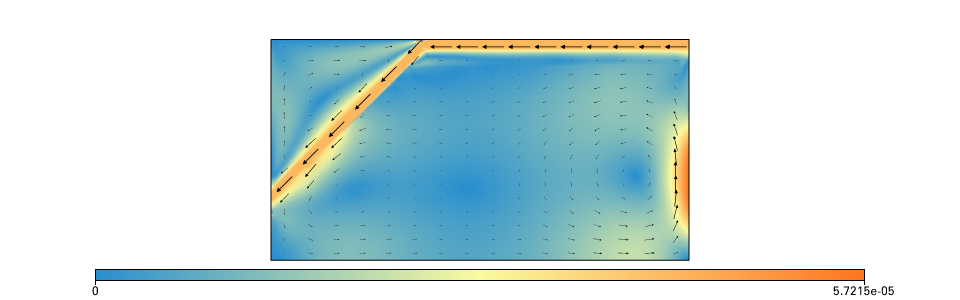

In [40]:
store = vis.Store('output/AccuVisc3')
figVelocityMag = vis.Figure(figsize=(960,300), name="VeloVectors" )
figVelocityMag.append( vis.objects.Surface(mesh, fn.math.sqrt(fn.math.dot(velocityField,velocityField))) )
figVelocityMag.VectorArrows(mesh, velocityField)
figVelocityMag.show()


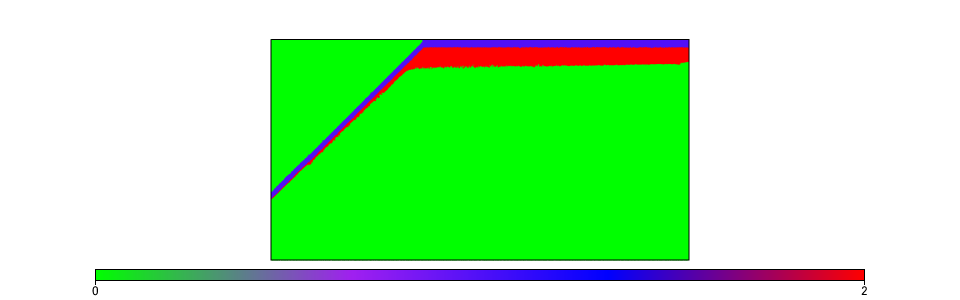

In [41]:
store = vis.Store('output/AccuVisc3')
figParticle = vis.Figure( store, figsize=(960,300), name="Particles" )
figParticle.append( vis.objects.Points(swarm, materialVariable, pointSize=2, colours='green purple blue red') )
figParticle.show()

Post simulation analysis
-----

Plot all figures for the resulting system using LavaVu to load the saved visualisation.
This allows us to open a previously saved visualisation database, just pass the same name used when creating the Store object

In [42]:
import underworld.visualisation as vis
viewer = vis.Viewer('output/AccuVisc3')
viewer.step = 800

Here we print some information about the loaded visualisation which shows what data is available
(as we only gave our first figure a name "Particles" the others have been automatically named)

In [43]:
figs = viewer.figures
steps = viewer.steps
if rank==0:
    print("Saved database '%s'" % (viewer.filename))
    print(" - %d figures : %s" % (len(figs), str(figs.keys())))
    print(" - %d timesteps (final = %d) : %s" % (len(steps), steps[-1], steps))

Saved database 'output/AccuVisc3.gldb'
 - 1 figures : dict_keys(['Particles'])
 - 31 timesteps (final = 300) : [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]


We just want to look at the final state of the simulation, so set the timestep to the last one in the list and loop through all the figures, plotting each one

In [44]:
#grab the mantle below the slab only
ugh = mesh.specialSets['Empty']
for index,coord in enumerate(mesh.data):
    if coord [0] < apex and coord[1] < (m* coord[0] + 0.0 - slabh) - 0.05 and coord[1] > -0.25:
        ugh.add(index)
        
        
gah = mesh.specialSets['Empty']
for index,coord in enumerate(mesh.data):
    if coord [0] >= apex and coord[1] < 0.0 - slabh and coord[1] > -0.25:
        gah.add(index)





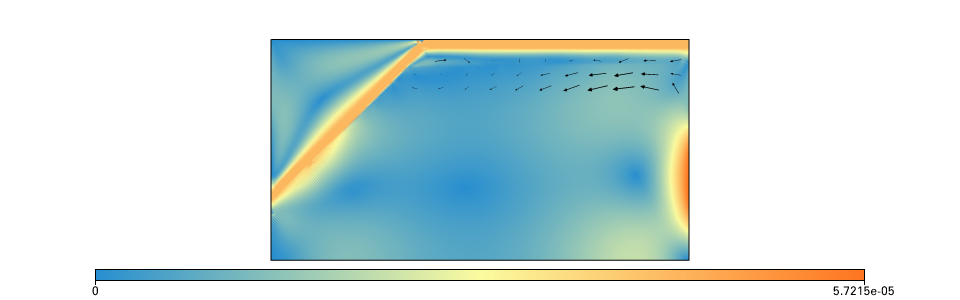

In [45]:
blah = mesh.add_variable(         nodeDofCount=2 )
blah.data[:] = [0.,0.]
blah.data[ugh] = velocityField.data[ugh]
blah.data[gah] = velocityField.data[gah]
store = vis.Store('output/AccuVisc3')
figVelocityMag = vis.Figure(figsize=(960,300), name="VeloVectors" )
figVelocityMag.append( vis.objects.Surface(mesh, fn.math.sqrt(fn.math.dot(velocityField,velocityField))) )
figVelocityMag.VectorArrows(mesh, blah)
figVelocityMag.show()


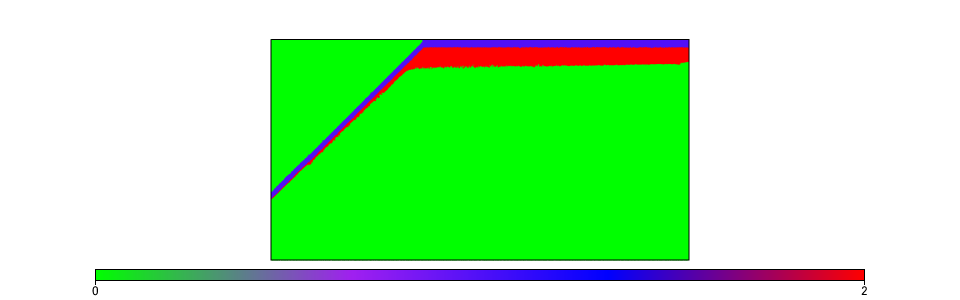

In [46]:
figParticle = vis.Figure( store, figsize=(960,300), name="Particles" )
figParticle.append( vis.objects.Points(swarm, materialVariable, pointSize=2, colours='green purple blue red') )
figParticle.show()